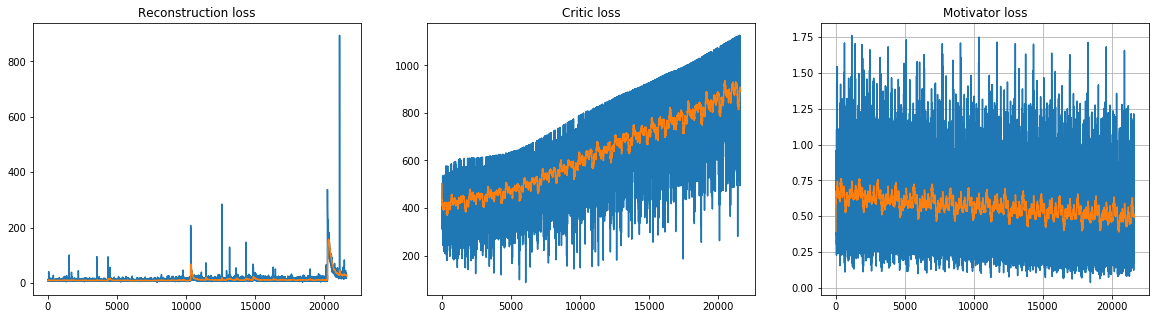

In [ ]:
import math
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

rec_loss_history = []
critic_loss_history = []
motivator_loss_history = []
num_iters_done = 0
num_epochs_done = 0
max_num_epochs = 100

while num_epochs_done < max_num_epochs:
    for batch in data_iter:
        # Computing codes we need
        style_modern, content_modern = encoder(batch.modern)
        style_original, content_original = encoder(batch.original)

        # Now we should merge back style and content for decoder
        hid_modern = torch.cat([style_modern, content_modern], dim=1)
        hid_original = torch.cat([style_original, content_original], dim=1)

        # Reconstructing
        recs_modern = decoder(hid_modern, batch.modern[:, :-1])
        recs_original = decoder(hid_original, batch.original[:, :-1])

        # Computing reconstruction loss
        rec_loss_modern = rec_criterion(recs_modern.view(-1, voc_size), batch.modern[:, 1:].contiguous().view(-1))
        rec_loss_original = rec_criterion(recs_original.view(-1, voc_size), batch.original[:, 1:].contiguous().view(-1))
        rec_loss = rec_loss_modern + rec_loss_original

        # Computing critic loss
        critic_loss = critic_criterion(content_modern, content_original)

        # Computing motivator loss
        motivator_logits_modern = motivator(style_modern)
        motivator_logits_original = motivator(style_original)
        motivator_loss_modern = motivator_criterion(motivator_logits_modern, torch.ones_like(motivator_logits_modern))
        motivator_loss_original = motivator_criterion(motivator_logits_original, torch.zeros_like(motivator_logits_original))
        motivator_loss = motivator_loss_modern + motivator_loss_original
        
        # Loss for encoder and decoder is threefold
        ae_loss = rec_loss + motivator_loss - critic_loss

        # Now we can make backward passes
        critic_optim.zero_grad()
        critic_loss.backward(retain_graph=True)
        critic_optim.step()

        ae_optim.zero_grad()
        motivator_optim.zero_grad()
        motivator_loss.backward(retain_graph=True)
        motivator_optim.step()
        ae_optim.step()

        ae_optim.zero_grad()
        ae_loss.backward(retain_graph=True)
        ae_optim.step()

        rec_loss_history.append(rec_loss.item())
        critic_loss_history.append(critic_loss.item())
        motivator_loss_history.append(motivator_loss.item())

        if num_iters_done % 10 == 0:
            clear_output(True)
            plt.figure(figsize=[20,5])

            plt.subplot(131)
            plt.title("Reconstruction loss")
            plt.plot(rec_loss_history)
            plt.plot(pd.DataFrame(np.array(rec_loss_history)).ewm(span=100).mean())

            plt.subplot(132)
            plt.title("Critic loss")
            plt.plot(critic_loss_history)
            plt.plot(pd.DataFrame(np.array(critic_loss_history)).ewm(span=100).mean())

            plt.subplot(133)
            plt.title("Motivator loss")
            plt.plot(motivator_loss_history)
            plt.plot(pd.DataFrame(np.array(motivator_loss_history)).ewm(span=100).mean())

            plt.grid()
            plt.show()

        num_iters_done += 1
    
    num_epochs_done += 1

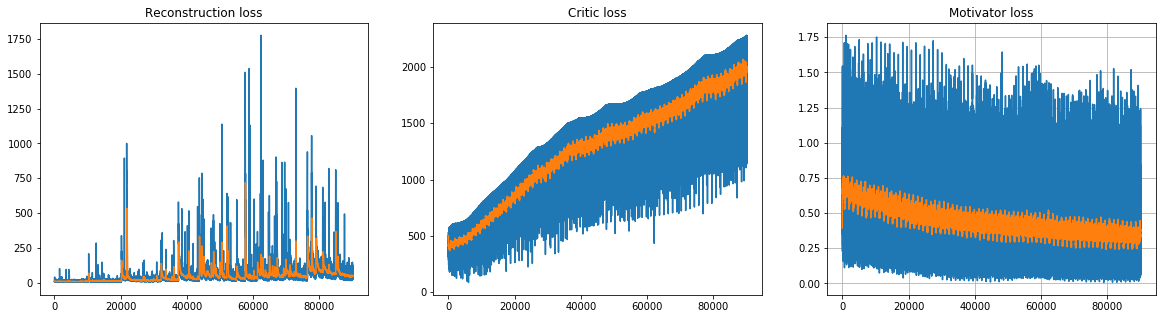

In [8]:
plt.figure(figsize=[20,5])

plt.subplot(131)
plt.title("Reconstruction loss")
plt.plot(rec_loss_history)
plt.plot(pd.DataFrame(np.array(rec_loss_history)).ewm(span=100).mean())

plt.subplot(132)
plt.title("Critic loss")
plt.plot(critic_loss_history)
plt.plot(pd.DataFrame(np.array(critic_loss_history)).ewm(span=100).mean())

plt.subplot(133)
plt.title("Motivator loss")
plt.plot(motivator_loss_history)
plt.plot(pd.DataFrame(np.array(motivator_loss_history)).ewm(span=100).mean())

plt.grid()
plt.show()

In [12]:
def inference(model, z, vocab, max_len=100):
    """
    All decoder models have the same inference procedure
    Let's move it into the common function
    """
    batch_size = z.size(0)
    BOS, EOS = vocab.stoi['<bos>'], vocab.stoi['<eos>']
    active_seqs = cudable(torch.tensor([[BOS] for _ in range(batch_size)]).long())
    active_seqs_idx = np.arange(batch_size)
    finished = [None for _ in range(batch_size)]
    n_finished = 0

    for _ in range(max_len):
        next_tokens = model.forward(z, active_seqs).max(dim=-1)[1][:,-1] # TODO: use beam search
        active_seqs = torch.cat((active_seqs, next_tokens.unsqueeze(1)), dim=-1)
        finished_mask = (next_tokens == EOS).cpu().numpy().astype(bool)
        finished_seqs_idx = active_seqs_idx[finished_mask]
        active_seqs_idx = active_seqs_idx[finished_mask == 0]
        n_finished += finished_seqs_idx.size

        if finished_seqs_idx.size != 0:
            # TODO(universome)
            # finished[finished_seqs_idx] = active_seqs.masked_select(next_tokens == EOS).cpu().numpy()
            for i, seq in zip(finished_seqs_idx, active_seqs[next_tokens == EOS]):
                finished[i] = seq.cpu().numpy().tolist()

            active_seqs = active_seqs[next_tokens != EOS]
            z = z[next_tokens != EOS]

        if n_finished == batch_size: break

    # Well, some sentences were finished at the time
    # Let's just fill them in
    if n_finished != batch_size:
        # TODO(universome): finished[active_seqs_idx] = active_seqs
        for i, seq in zip(active_seqs_idx, active_seqs):
            finished[i] = seq.cpu().numpy().tolist()

    return finished


def transfer_style(sentences_modern, sentences_original, vocab):
    style_modern, content_modern = encoder(batch.modern)
    style_original, content_original = encoder(batch.original)
    
    modern_to_original_z = torch.cat([style_original, content_modern], dim=1)
    original_to_modern_z = torch.cat([style_modern, content_original], dim=1)
    
    modern_to_original_recs = inference(decoder, modern_to_original_z, vocab)
    original_to_modern_recs = inference(decoder, original_to_modern_z, vocab)
    
    return modern_to_original_recs, original_to_modern_recs


def itos_many(seqs, vocab):
    """
    Converts sequences of token ids to normal strings
    """
    SPECIAL_TOKENS = {'<bos>', '<eos>', '<pad>'}
    
    sents = [[vocab.itos[i] for i in seq] for seq in seqs]
    sents = [[t for t in s if not t in SPECIAL_TOKENS] for s in sents]
    sents = [' '.join(s).replace('@@ ', '') for s in sents]

    return sents

In [14]:
m, o = transfer_style(batch.modern, batch.original, text.vocab)

In [16]:
itos_many(o, text.vocab)

['&apos;t worry about about .',
 'worrying ?',
 'worrying about mine .',
 '&apos;t damage - unless you gouged !',
 '&apos;t damage mine shall shall damage graves shall damage graves shall damage graves shall damage damage graves shall damage ) during shall damage ... &apos;t damage shall damage damage &apos;t damage shall damage damage graves shall damage ) during this merciless during graves at graves graves shall damage damage graves shall damage ) during this desolate graves !',
 'worrying ?',
 'worrying about mine .',
 '&apos;t worry about mine !',
 '&apos;t worry about mine .',
 'worrying about you .',
 'worrying about mine .',
 '&apos;t damage .',
 'worrying about ?',
 '&apos;t damage .',
 'Let us be satisfied .',
 '&apos;t worry about about about ) during this during this during about .']